# 2. Data Preprocessing - Airbnb New User Booking Prediction

## Objective
Clean and prepare the data for modeling by handling missing values, encoding categorical variables, normalizing features, extracting date features, and creating new features.

## Import Required Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Set plotting style
sns.set_palette('viridis')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.2f}'.format)

## Load Datasets

We'll load the same datasets that we explored in the previous notebook.

In [3]:
# Define file paths
train_path = '../train_users_2.csv'
test_path = '../test_users.csv'
sessions_path = '../sessions.csv'

# Create directories for processed data if they don't exist
os.makedirs('../data/processed', exist_ok=True)

# Load train data
train_df = pd.read_csv(train_path)
print(f"Train data shape: {train_df.shape}")

# Load test data
test_df = pd.read_csv(test_path)
print(f"Test data shape: {test_df.shape}")

# Load sessions data (with low_memory=False to avoid mixed dtype warning)
sessions_df = pd.read_csv(sessions_path, low_memory=False)
print(f"Sessions data shape: {sessions_df.shape}")

Train data shape: (213451, 16)
Test data shape: (62096, 15)
Sessions data shape: (10567737, 6)
Sessions data shape: (10567737, 6)


## 1. Handle Missing Values and Outliers

In [4]:
# Create a copy of the DataFrames to work with
train_clean = train_df.copy()
test_clean = test_df.copy()

# Check missing values again to confirm
missing_train = train_clean.isnull().sum()
print("Missing values in training data:")
print(missing_train[missing_train > 0])

Missing values in training data:
date_first_booking         124543
age                         87990
first_affiliate_tracked      6065
dtype: int64


### 1.1 Handle Age Outliers and Missing Values

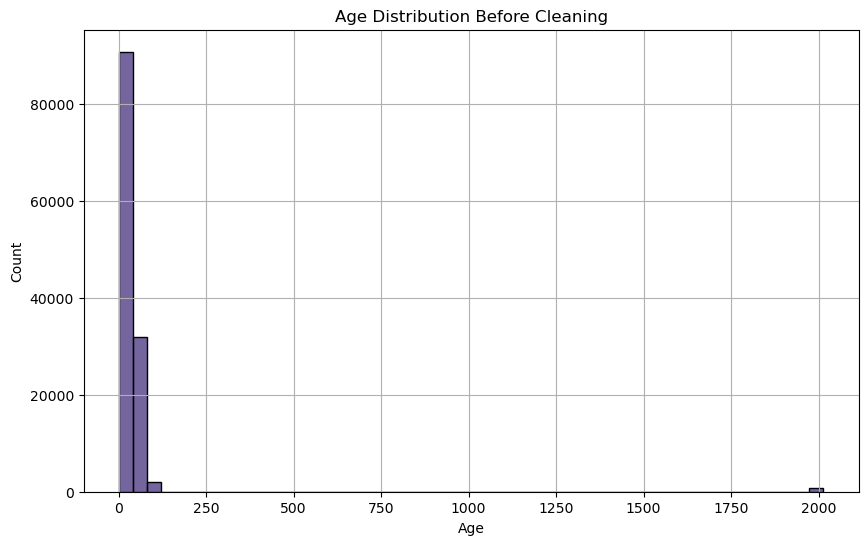

Age range before cleaning: 1.0 - 2014.0
Number of users with age < 14: 57
Number of users with age > 100: 2345


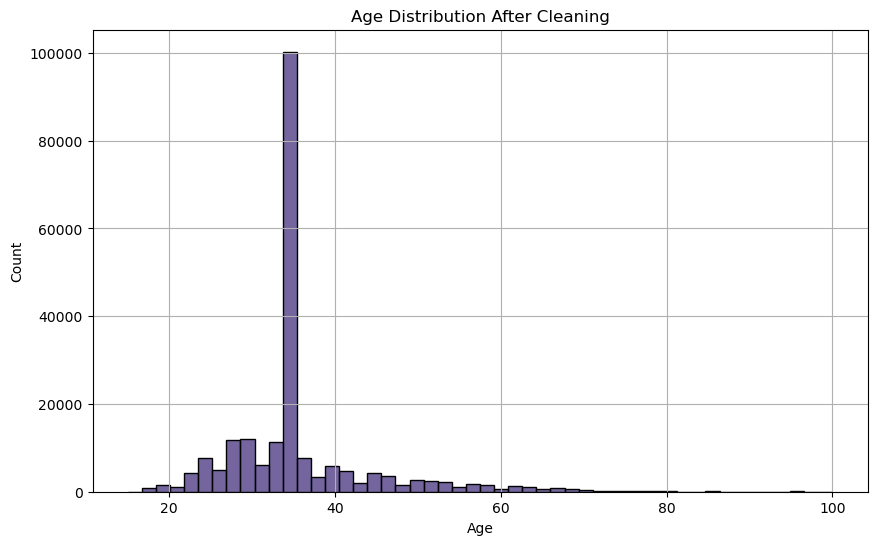

Age range after cleaning: 15.0 - 100.0


In [5]:
# Plot age distribution before cleaning
plt.figure(figsize=(10, 6))
sns.histplot(train_clean['age'].dropna(), bins=50)
plt.title('Age Distribution Before Cleaning')
plt.xlabel('Age')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# Identify age outliers
print(f"Age range before cleaning: {train_clean['age'].min()} - {train_clean['age'].max()}")
print(f"Number of users with age < 14: {(train_clean['age'] < 14).sum()}")
print(f"Number of users with age > 100: {(train_clean['age'] > 100).sum()}")

# Replace outliers with NaN
train_clean.loc[(train_clean['age'] < 14) | (train_clean['age'] > 100), 'age'] = np.nan
test_clean.loc[(test_clean['age'] < 14) | (test_clean['age'] > 100), 'age'] = np.nan

# Impute missing age values with median
age_median = train_clean['age'].median()
train_clean['age'].fillna(age_median, inplace=True)
test_clean['age'].fillna(age_median, inplace=True)

# Plot age distribution after cleaning
plt.figure(figsize=(10, 6))
sns.histplot(train_clean['age'], bins=50)
plt.title('Age Distribution After Cleaning')
plt.xlabel('Age')
plt.ylabel('Count')
plt.grid(True)
plt.show()

print(f"Age range after cleaning: {train_clean['age'].min()} - {train_clean['age'].max()}")

### 1.2 Handle Missing Gender Values

In [6]:
# Check gender distribution
print("Gender distribution before imputation:")
print(train_clean['gender'].value_counts(dropna=False))

# Fill missing gender with the most frequent value
most_common_gender = train_clean['gender'].mode()[0]
train_clean['gender'].fillna(most_common_gender, inplace=True)
test_clean['gender'].fillna(most_common_gender, inplace=True)

# Check gender distribution after imputation
print("\nGender distribution after imputation:")
print(train_clean['gender'].value_counts(dropna=False))

Gender distribution before imputation:
gender
-unknown-    95688
FEMALE       63041
MALE         54440
OTHER          282
Name: count, dtype: int64

Gender distribution after imputation:
gender
-unknown-    95688
FEMALE       63041
MALE         54440
OTHER          282
Name: count, dtype: int64


### 1.3 Handle Other Missing Values

In [7]:
# For categorical variables: fill with the most frequent value
categorical_cols = ['first_browser', 'first_device_type', 'signup_method', 'signup_flow', 'language']

for col in categorical_cols:
    most_common_val = train_clean[col].mode()[0]
    train_clean[col].fillna(most_common_val, inplace=True)
    test_clean[col].fillna(most_common_val, inplace=True)

# Check if there are any remaining missing values
missing_after = train_clean.isnull().sum()
print("Remaining missing values in training data:")
print(missing_after[missing_after > 0])

Remaining missing values in training data:
date_first_booking         124543
first_affiliate_tracked      6065
dtype: int64


## 2. Date Feature Engineering

In [8]:
# Convert date_account_created to datetime
train_clean['date_account_created'] = pd.to_datetime(train_clean['date_account_created'])
test_clean['date_account_created'] = pd.to_datetime(test_clean['date_account_created'])

# Convert timestamp_first_active to datetime
train_clean['timestamp_first_active'] = pd.to_datetime(train_clean['timestamp_first_active'].astype(str), format='%Y%m%d%H%M%S')
test_clean['timestamp_first_active'] = pd.to_datetime(test_clean['timestamp_first_active'].astype(str), format='%Y%m%d%H%M%S')

# Extract date components from date_account_created
for df in [train_clean, test_clean]:
    # Year, month, day
    df['dac_year'] = df['date_account_created'].dt.year
    df['dac_month'] = df['date_account_created'].dt.month
    df['dac_day'] = df['date_account_created'].dt.day
    df['dac_dayofweek'] = df['date_account_created'].dt.dayofweek
    # Is weekend?
    df['dac_is_weekend'] = df['dac_dayofweek'].isin([5, 6]).astype(int)
    # Quarter
    df['dac_quarter'] = df['date_account_created'].dt.quarter

    # Extract time components from timestamp_first_active
    df['tfa_year'] = df['timestamp_first_active'].dt.year
    df['tfa_month'] = df['timestamp_first_active'].dt.month
    df['tfa_day'] = df['timestamp_first_active'].dt.day
    df['tfa_hour'] = df['timestamp_first_active'].dt.hour
    df['tfa_dayofweek'] = df['timestamp_first_active'].dt.dayofweek
    df['tfa_is_weekend'] = df['tfa_dayofweek'].isin([5, 6]).astype(int)
    df['tfa_quarter'] = df['timestamp_first_active'].dt.quarter

    # Create features for time between first active and account creation
    df['days_between_first_active_and_account_created'] = (df['date_account_created'] - df['timestamp_first_active']).dt.total_seconds() / (60 * 60 * 24)

# Check new date features
date_cols = [col for col in train_clean.columns if col.startswith('dac_') or col.startswith('tfa_') or col == 'days_between_first_active_and_account_created']
train_clean[date_cols].head()

,dac_year,dac_month,dac_day,dac_dayofweek,dac_is_weekend,dac_quarter,tfa_year,tfa_month,tfa_day,tfa_hour,tfa_dayofweek,tfa_is_weekend,tfa_quarter,days_between_first_active_and_account_created
0,2010,6,28,0,0,2,2009,3,19,4,3,0,1,465.81
1,2011,5,25,2,0,2,2009,5,23,17,5,1,2,731.26
2,2010,9,28,1,0,3,2009,6,9,23,1,0,2,475.03
3,2011,12,5,0,0,4,2009,10,31,6,5,1,4,764.75
4,2010,9,14,1,0,3,2009,12,8,6,1,0,4,279.74


## 3. Session Data Feature Engineering

Extract user-level behavior stats from the sessions data:

In [9]:
# Check if sessions data exists for all users in train and test sets
train_users = set(train_clean['id'])
test_users = set(test_clean['id'])
session_users = set(sessions_df['user_id'])

print(f"Number of users in train set: {len(train_users)}")
print(f"Number of users in test set: {len(test_users)}")
print(f"Number of users in sessions data: {len(session_users)}")
print(f"Number of train users with session data: {len(train_users.intersection(session_users))}")
print(f"Number of test users with session data: {len(test_users.intersection(session_users))}")

Number of users in train set: 213451
Number of users in test set: 62096
Number of users in sessions data: 135484
Number of train users with session data: 73815
Number of test users with session data: 61668


In [10]:
# Create session features by user
print("Creating session features...")

# Total sessions per user
user_sessions_count = sessions_df.groupby('user_id').size().reset_index(name='total_sessions')

# Total time spent (sum of secs_elapsed)
user_time_spent = sessions_df.groupby('user_id')['secs_elapsed'].sum().reset_index(name='total_secs_elapsed')

# Average time spent per session
user_avg_time = sessions_df.groupby('user_id')['secs_elapsed'].mean().reset_index(name='avg_secs_elapsed')

# Most common action type per user
user_most_common_action_type = sessions_df.groupby('user_id')['action_type'].agg(
    lambda x: x.value_counts().index[0] if len(x.value_counts()) > 0 else np.nan
).reset_index(name='most_common_action_type')

# Most common action per user
user_most_common_action = sessions_df.groupby('user_id')['action'].agg(
    lambda x: x.value_counts().index[0] if len(x.value_counts()) > 0 else np.nan
).reset_index(name='most_common_action')

# Most common device type per user
user_most_common_device = sessions_df.groupby('user_id')['device_type'].agg(
    lambda x: x.value_counts().index[0] if len(x.value_counts()) > 0 else np.nan
).reset_index(name='most_common_device')

# Count of unique actions per user (action diversity)
user_action_diversity = sessions_df.groupby('user_id')['action'].nunique().reset_index(name='action_diversity')

# Count of unique action types per user
user_action_type_diversity = sessions_df.groupby('user_id')['action_type'].nunique().reset_index(name='action_type_diversity')

# Count of unique device types per user (device diversity)
user_device_diversity = sessions_df.groupby('user_id')['device_type'].nunique().reset_index(name='device_diversity')

# Merge all session features
session_features = user_sessions_count.merge(
    user_time_spent, on='user_id', how='left'
).merge(
    user_avg_time, on='user_id', how='left'
).merge(
    user_most_common_action_type, on='user_id', how='left'
).merge(
    user_most_common_action, on='user_id', how='left'
).merge(
    user_most_common_device, on='user_id', how='left'
).merge(
    user_action_diversity, on='user_id', how='left'
).merge(
    user_action_type_diversity, on='user_id', how='left'
).merge(
    user_device_diversity, on='user_id', how='left'
)

# Rename user_id to id to match with train and test data
session_features.rename(columns={'user_id': 'id'}, inplace=True)

# Display session features
print("\nSession features shape:", session_features.shape)
session_features.head()

Creating session features...

Session features shape: (135483, 10)

Session features shape: (135483, 10)


,id,total_sessions,total_secs_elapsed,avg_secs_elapsed,most_common_action_type,most_common_action,most_common_device,action_diversity,action_type_diversity,device_diversity
0,00023iyk9l,40,867896.00,22253.74,view,show,Mac Desktop,13,6,2
1,0010k6l0om,63,586543.00,9460.37,view,show,Mac Desktop,11,5,1
2,001wyh0pz8,90,282965.00,3179.38,click,search,Android App Unknown Phone/Tablet,10,5,1
3,0028jgx1x1,31,297010.00,9900.33,view,show,-unknown-,5,5,2
4,002qnbzfs5,789,6487080.00,8232.34,view,show,iPhone,25,7,2


In [11]:
# Merge session features with train and test data
train_clean = train_clean.merge(session_features, on='id', how='left')
test_clean = test_clean.merge(session_features, on='id', how='left')

# Fill missing session features with zeros
session_feature_cols = session_features.columns.drop('id').tolist()
train_clean[session_feature_cols] = train_clean[session_feature_cols].fillna(0)
test_clean[session_feature_cols] = test_clean[session_feature_cols].fillna(0)

# Display updated dataset
print("Train data with session features shape:", train_clean.shape)
print("Test data with session features shape:", test_clean.shape)

Train data with session features shape: (213451, 39)
Test data with session features shape: (62096, 38)


## 4. Additional Feature Engineering

### 4.1 Age Groups

In [12]:
# Create age groups
def categorize_age(age):
    if age < 25:
        return 'Young Adult'
    elif age < 40:
        return 'Adult'
    elif age < 60:
        return 'Middle-Aged'
    else:
        return 'Senior'

train_clean['age_group'] = train_clean['age'].apply(categorize_age)
test_clean['age_group'] = test_clean['age'].apply(categorize_age)

# Check distribution of age groups
print("Age group distribution:")
train_clean['age_group'].value_counts()

Age group distribution:


age_group
Adult          165105
Middle-Aged     30731
Young Adult     10778
Senior           6837
Name: count, dtype: int64

### 4.2 Feature for Signup Method and Signup Flow Combinations

In [13]:
# Create a combined feature for signup method and flow
train_clean['signup_method_flow'] = train_clean['signup_method'] + '_' + train_clean['signup_flow'].astype(str)
test_clean['signup_method_flow'] = test_clean['signup_method'] + '_' + test_clean['signup_flow'].astype(str)

# Check distribution
print("Top 10 signup method-flow combinations:")
train_clean['signup_method_flow'].value_counts().head(10)

Top 10 signup method-flow combinations:


signup_method_flow
basic_0        118653
facebook_0      46086
basic_25        12889
basic_3          6395
facebook_12      6321
basic_2          4544
basic_24         3919
basic_23         2517
basic_12         2462
facebook_3       2427
Name: count, dtype: int64

### 4.3 Advanced Feature Engineering: Activity Ratios, Recency, and Booking Propensity

We add new features to capture user activity patterns, recency, and booking propensity.

In [14]:
# Advanced feature engineering
for df in [train_clean, test_clean]:
    # Actions per session (avoid division by zero)
    df['actions_per_session'] = df['action_diversity'] / (df['total_sessions'] + 1e-5)
    # Time per session
    df['secs_per_session'] = df['total_secs_elapsed'] / (df['total_sessions'] + 1e-5)
    # Device diversity ratio
    df['device_diversity_ratio'] = df['device_diversity'] / (df['total_sessions'] + 1e-5)
    # Action type diversity ratio
    df['action_type_diversity_ratio'] = df['action_type_diversity'] / (df['total_sessions'] + 1e-5)
    # Booking propensity: ratio of booking-related actions (if available)
    if 'most_common_action' in df.columns:
        df['booking_action_flag'] = df['most_common_action'].astype(str).str.contains('book|booking|reservation', case=False, na=False).astype(int)
    # Recency: days since account created to a fixed reference date (e.g., last date in dataset)
    reference_date = pd.to_datetime('2015-07-01')
    if 'date_account_created' in df.columns:
        df['days_since_account_created'] = (reference_date - df['date_account_created']).dt.days

## 5. Categorical Variable Encoding

### 5.1 Identify Categorical Variables

In [15]:
# Identify categorical columns
categorical_columns = [
    'gender', 'signup_method', 'language', 'affiliate_channel',
    'affiliate_provider', 'first_affiliate_tracked', 'signup_app',
    'first_device_type', 'first_browser', 'most_common_action_type',
    'most_common_action', 'most_common_device', 'age_group',
    'signup_method_flow'
]

# Categorical columns with potential high cardinality
high_cardinality_cols = ['most_common_action']

# Check cardinality of each categorical column
for col in categorical_columns:
    unique_count = train_clean[col].nunique()
    print(f"{col}: {unique_count} unique values")

gender: 4 unique values
signup_method: 3 unique values
language: 25 unique values
affiliate_channel: 8 unique values
affiliate_provider: 18 unique values
first_affiliate_tracked: 7 unique values
signup_app: 4 unique values
first_device_type: 9 unique values
first_browser: 52 unique values
most_common_action_type: 9 unique values
most_common_action: 165 unique values
most_common_device: 14 unique values
age_group: 4 unique values
signup_method_flow: 27 unique values


### 5.2 Label Encoding for Categorical Columns

For columns with high cardinality we'll use label encoding, and for others we'll use one-hot encoding.

In [16]:
# Apply Label encoding for high cardinality categorical variables
from sklearn.preprocessing import LabelEncoder

# Initialize an empty dictionary to store the label encoders
label_encoders = {}

# Apply a more robust label encoding to high cardinality columns
for col in high_cardinality_cols:
    if col in train_clean.columns:
        # Create a combined set of unique values from both train and test
        all_values = set(train_clean[col].astype(str).unique()).union(set(test_clean[col].astype(str).unique()))
        print(f"Total unique values in {col}: {len(all_values)}")
        
        # Create a mapping dictionary with an integer for each unique value
        value_to_int = {val: idx for idx, val in enumerate(all_values)}
        
        # Apply the mapping
        train_clean[f'{col}_encoded'] = train_clean[col].astype(str).map(value_to_int)
        test_clean[f'{col}_encoded'] = test_clean[col].astype(str).map(value_to_int)
        
        print(f"Label encoded {col} with {len(all_values)} classes")

# Check the encoded columns
for col in high_cardinality_cols:
    if col in train_clean.columns:
        print(f"\nSample of {col}_encoded:")
        print(train_clean[[col, f'{col}_encoded']].head())

Total unique values in most_common_action: 188
Label encoded most_common_action with 188 classes

Sample of most_common_action_encoded:
  most_common_action  most_common_action_encoded
0                  0                         171
1                  0                         171
2                  0                         171
3                  0                         171
4                  0                         171


### 5.3 One-Hot Encoding for Other Categorical Variables

In [17]:
# Identify columns for one-hot encoding (excluding high cardinality ones)
onehot_cols = [col for col in categorical_columns if col not in high_cardinality_cols]

# Apply one-hot encoding
train_encoded = pd.get_dummies(train_clean, columns=onehot_cols, drop_first=True)
test_encoded = pd.get_dummies(test_clean, columns=onehot_cols, drop_first=True)

# Ensure test_encoded has same columns as train_encoded
for col in train_encoded.columns:
    if col not in test_encoded.columns and col != 'country_destination':
        test_encoded[col] = 0

# Ensure columns are in the same order
test_encoded = test_encoded[train_encoded.columns.drop('country_destination') if 'country_destination' in train_encoded.columns else train_encoded.columns]

# Check the shapes after encoding
print(f"Train shape after encoding: {train_encoded.shape}")
print(f"Test shape after encoding: {test_encoded.shape}")

# Show the first few columns to verify encoding worked correctly
train_encoded.head(3)

Train shape after encoding: (213451, 206)
Test shape after encoding: (62096, 205)


,id,date_account_created,timestamp_first_active,date_first_booking,age,signup_flow,country_destination,dac_year,dac_month,dac_day,dac_dayofweek,dac_is_weekend,dac_quarter,tfa_year,tfa_month,tfa_day,tfa_hour,tfa_dayofweek,tfa_is_weekend,tfa_quarter,days_between_first_active_and_account_created,total_sessions,total_secs_elapsed,avg_secs_elapsed,most_common_action,action_diversity,action_type_diversity,device_diversity,actions_per_session,secs_per_session,device_diversity_ratio,action_type_diversity_ratio,booking_action_flag,days_since_account_created,most_common_action_encoded,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_facebook,signup_method_google,language_cs,language_da,language_de,language_el,language_en,language_es,language_fi,language_fr,language_hr,language_hu,language_id,language_is,language_it,language_ja,language_ko,language_nl,language_no,language_pl,language_pt,language_ru,language_sv,language_th,language_tr,language_zh,affiliate_channel_content,affiliate_channel_direct,affiliate_channel_other,affiliate_channel_remarketing,affiliate_channel_sem-brand,affiliate_channel_sem-non-brand,affiliate_channel_seo,affiliate_provider_bing,affiliate_provider_craigslist,affiliate_provider_daum,affiliate_provider_direct,affiliate_provider_email-marketing,affiliate_provider_facebook,affiliate_provider_facebook-open-graph,affiliate_provider_google,affiliate_provider_gsp,affiliate_provider_meetup,affiliate_provider_naver,affiliate_provider_other,affiliate_provider_padmapper,affiliate_provider_vast,affiliate_provider_wayn,affiliate_provider_yahoo,affiliate_provider_yandex,first_affiliate_tracked_local ops,first_affiliate_tracked_marketing,first_affiliate_tracked_omg,first_affiliate_tracked_product,first_affiliate_tracked_tracked-other,first_affiliate_tracked_untracked,signup_app_Moweb,signup_app_Web,signup_app_iOS,first_device_type_Android Tablet,first_device_type_Desktop (Other),first_device_type_Mac Desktop,first_device_type_Other/Unknown,first_device_type_SmartPhone (Other),first_device_type_Windows Desktop,first_device_type_iPad,first_device_type_iPhone,first_browser_AOL Explorer,first_browser_Android Browser,first_browser_Apple Mail,first_browser_Arora,first_browser_Avant Browser,first_browser_BlackBerry Browser,first_browser_Camino,first_browser_Chrome,first_browser_Chrome Mobile,first_browser_Chromium,first_browser_CometBird,first_browser_Comodo Dragon,first_browser_Conkeror,first_browser_CoolNovo,first_browser_Crazy Browser,first_browser_Epic,first_browser_Firefox,first_browser_Flock,first_browser_Google Earth,first_browser_Googlebot,first_browser_IE,first_browser_IE Mobile,first_browser_IceDragon,first_browser_IceWeasel,first_browser_Iron,first_browser_Kindle Browser,first_browser_Maxthon,first_browser_Mobile Firefox,first_browser_Mobile Safari,first_browser_Mozilla,first_browser_NetNewsWire,first_browser_OmniWeb,first_browser_Opera,first_browser_Opera Mini,first_browser_Opera Mobile,first_browser_Outlook 2007,first_browser_PS Vita browser,first_browser_Pale Moon,first_browser_Palm Pre web browser,first_browser_RockMelt,first_browser_Safari,first_browser_SeaMonkey,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser,most_common_action_type_-unknown-,most_common_action_type_booking_request,most_common_action_type_click,most_common_action_type_data,most_common_action_type_message_post,most_common_action_type_partner_callback,most_common_action_type_submit,most_common_action_type_view,most_common_device_-unknown-,most_common_device_Android App Unknown Phone/Tablet,most_common_device_Android Phone,most_common_device_Blackberry,most_common_device_Chromebook,most_common_device_Linux Desktop,most_common_device_Mac Desktop,most_common_device_Tablet,most_common_device_Windows Desktop,most_common_device_Windows Phone,most_common_device_iPad Tablet,most

## 6. Numerical Feature Scaling

In [18]:
# Identify numerical columns to scale (excluding IDs and dates and the target column)
numerical_cols = ['age', 'total_sessions', 'total_secs_elapsed', 'avg_secs_elapsed',
               'action_diversity', 'action_type_diversity', 'device_diversity',
               'days_between_first_active_and_account_created']

# Check if all the numerical columns exist in the DataFrames
numerical_cols = [col for col in numerical_cols if col in train_encoded.columns]

# Create a scaler
scaler = StandardScaler()

# Fit and transform the training data
train_encoded[numerical_cols] = scaler.fit_transform(train_encoded[numerical_cols])

# Transform the test data
test_encoded[numerical_cols] = scaler.transform(test_encoded[numerical_cols])

# Check the scaled columns
print("Numerical columns after scaling:")
train_encoded[numerical_cols].describe().T

Numerical columns after scaling:


,count,mean,std,min,25%,50%,75%,max
age,213451.00,0.00,1.00,-2.28,-0.39,-0.16,-0.05,7.20
total_sessions,213451.00,-0.00,1.00,-0.35,-0.35,-0.35,-0.15,34.82
total_secs_elapsed,213451.00,0.00,1.00,-0.39,-0.39,-0.39,-0.16,28.22
avg_secs_elapsed,213451.00,0.00,1.00,-0.29,-0.29,-0.29,-0.03,43.98
action_diversity,213451.00,-0.00,1.00,-0.57,-0.57,-0.57,0.48,8.77
action_type_diversity,213451.00,-0.00,1.00,-0.68,-0.68,-0.68,0.93,2.54
device_diversity,213451.00,0.00,1.00,-0.64,-0.64,-0.64,0.77,7.86
days_between_first_active_and_account_created,213451.00,-0.00,1.00,-0.06,-0.05,-0.03,0.01,121.80


## 7. Drop Unnecessary Columns

In [19]:
# Columns to drop (original date columns, original categorical columns that are now encoded, etc.)
cols_to_drop = [
    'date_account_created', 'timestamp_first_active',
    'date_first_booking'  # This might leak information about the target
]

# Drop columns from train data if they exist
for col in cols_to_drop:
    if col in train_encoded.columns:
        train_encoded.drop(col, axis=1, inplace=True)
        
    if col in test_encoded.columns:
        test_encoded.drop(col, axis=1, inplace=True)

# Check final shapes
print(f"Final train shape: {train_encoded.shape}")
print(f"Final test shape: {test_encoded.shape}")

Final train shape: (213451, 203)
Final test shape: (62096, 202)


## 8. Save Processed Data

In [20]:
# Save processed datasets to CSV
train_encoded.to_csv('../data/processed/train_processed.csv', index=False)
test_encoded.to_csv('../data/processed/test_processed.csv', index=False)

print("Processed data saved to '../data/processed/'")

Processed data saved to '../data/processed/'


## Summary of Preprocessing Steps

In this notebook, we performed the following preprocessing steps:

1. **Data Cleaning**:
   - Handled missing values in age, gender, and other categorical variables
   - Addressed age outliers (replaced ages < 14 or > 100 with NaN, then imputed)

2. **Feature Engineering**:
   - Created date features from `date_account_created` and `timestamp_first_active`
   - Extracted day of week, weekend indicator, and time between first active and account creation
   - Created age groups
   - Combined signup method and flow

3. **Session Data Aggregation**:
   - Total sessions per user
   - Total and average time spent
   - Most common action type, action, and device
   - Action and device diversity metrics

4. **Categorical Encoding**:
   - Applied label encoding to high-cardinality variables
   - Applied one-hot encoding to other categorical variables

5. **Numerical Scaling**:
   - Standardized numerical features using StandardScaler

6. **Data Organization**:
   - Dropped unnecessary columns
   - Saved processed datasets for modeling

The processed data is now ready for exploratory data analysis and model training in the next notebooks.